<a style="float:left;" href="https://colab.research.google.com/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-CIFAR_10-Reseau_Auto_Attentif/Identification_Objets-CIFAR_10-reseau_autoattentif.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<br/>
### Rappel - Fonctionnement d'un carnet web iPython

* Pour exécuter le code contenu dans une cellule d'un carnet iPython, cliquez dans la cellule et faites (⇧↵, shift-enter);
* Le code d'un carnet iPython s'exécute séquentiellement de haut en bas de la page. Souvent, l'importation d'une bibliothèque Python ou l'initialisation d'une variable est préalable à l'exécution d'une cellule située plus bas. Il est donc recommandé d'exécuter les cellules en séquence. Enfin, méfiez-vous des retours en arrière qui peuvent réinitialiser certaines variables;
* Pour obtenir de l'information sur une fonction, utilisez la commande Python `help(`"nom de la fonction"`)`

<b>SVP</b>, déployez toutes les cellules en sélectionnant l'item « Développer les rubriques » de l'onglet « Affichage ».

# Identification d'objets à partir de photos - jeu de données CIFAR-10

# par réseau autoattentif pour la vision

### Inspiration et droits d'auteur

Ce laboratoire s'inspire de plusieurs oeuvres en logiciels libres qui ont été transformées.

Il s'agit d'une implémentation un réseau autoattentif pour la vision, en anglais, Vision Transformer (ViT), basé sur l'article [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929/) par Alexey Dosovitskiy et al. pour la classification des images et le démontre sur l'ensemble de données CIFAR-100. Cette architecture autoattentive utilise des séquences de tuiles d'image, sans utiliser de couches de convolution.

Plus précisément, ce laboratoire est une traduction et adaptation par [Claude Coulombe](https://www.linkedin.com/in/claudecoulombe/) du [carnet IPython **« Image classification with Vision Transformer »**](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_with_vision_transformer.ipynb) de [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/) Description: Implementing the Vision Transformer (ViT) model for image classification.
<br/><br/>
##### Copyright (c) 2021, Alexey Dosovitskiy et al.
##### Copyright (c) 2021, Khalid Salama
##### Copyright (c) 2024, Claude Coulombe

# Installation

In [1]:
# !pip install --upgrade keras
!pip install keras==3.3.3
print()
print("Vous devez redémarrer la session")


Vous devez redémarrer la session


In [108]:
import tensorflow as tf
import keras
from keras import layers
from keras import ops

import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print("tensorFlow version:",tf.__version__)
print("keras version:",keras.__version__)
print("matplotlib:",matplotlib.__version__)



tensorFlow version: 2.15.0
keras version: 3.3.3
matplotlib: 3.7.1


## Prétraitement des données

### Jeu de données - photos CIFAR-10
L'ensemble de données CIFAR-10 (Canadian Institute For Advanced Research) comporte 60 000 photographies en couleur de 32×32 pixels d'objets de 10 classes différentes. Il est relativement simple d'atteindre une précision de 80 %. On peut obtenir des performances de 90 % pour ces données avec des réseaux neuronaux convolutifs.

* 0 : avion
* 1 : automobile
* 2 : oiseau
* 3 : chat
* 4 : cerf
* 5 : chien
* 6 : grenouille
* 7 : cheval
* 8 : bateau
* 9 : camion


Entraînement: attributs=(50000, 32, 32, 3), classes=(50000, 1)
Test: attributs=(10000, 32, 32, 3), classes=(10000, 1)

attributs_entrainement dim: (50000, 32, 32, 3) - y_train shape: (50000, 1)
attributs_test shape: (10000, 32, 32, 3) - classes_cibles_test shape: (10000, 1)

Quelques images avec leur étiquette...


<ipython-input-68-34676df1c280>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[i_rangee,i_colonne].set_title(dic_noms_etiquette[int(classes_cibles_entrainement[i_rangee*6+i_colonne])],


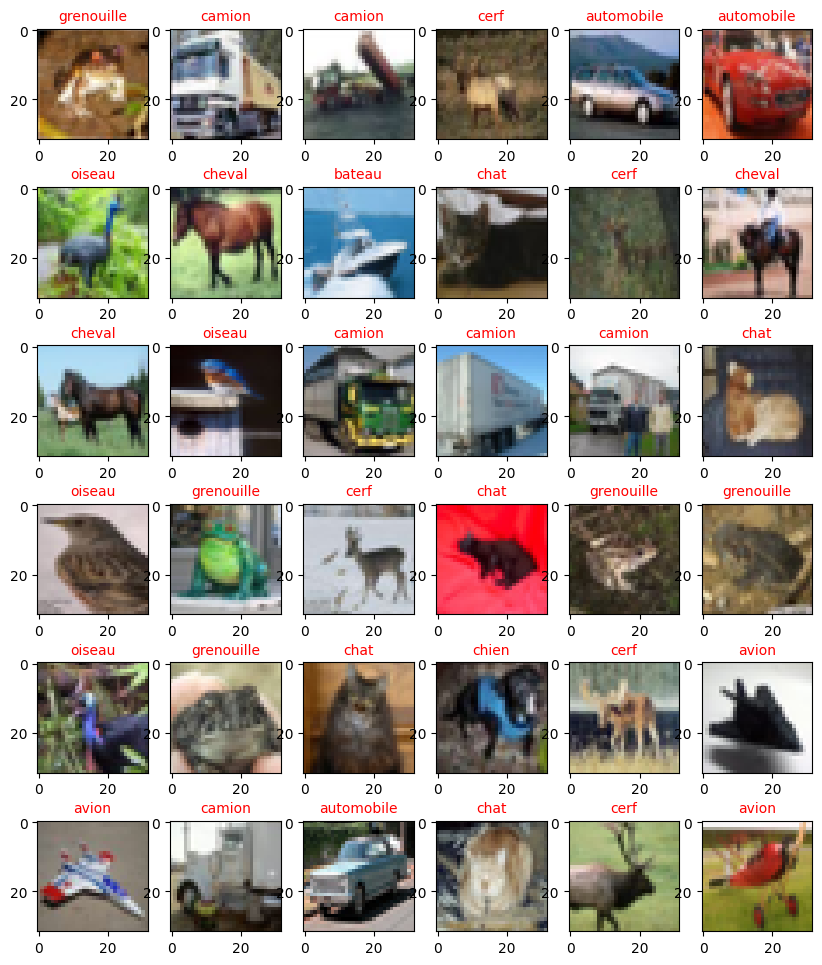

In [68]:
# le jeu de données CIFAR-10
from keras.datasets import cifar10

dic_noms_etiquette = {
    0 : "avion",
    1 : "automobile",
    2 : "oiseau",
    3 : "chat",
    4 : "cerf",
    5 : "chien",
    6 : "grenouille",
    7 : "cheval",
    8 : "bateau",
    9 : "camion",
}

nombre_classes = 10
dim_entree = (32, 32, 3)

# lire le jeu de données CIFAR-10 et le diviser entre
# les données d'entrainement et les données de test
(attributs_entrainement, classes_cibles_entrainement), (attributs_test, classes_cibles_test) = cifar10.load_data()

# Aperçu des tableaux de données
print()
print('Entraînement: attributs=%s, classes=%s' % (attributs_entrainement.shape, classes_cibles_entrainement.shape))
print('Test: attributs=%s, classes=%s' % (attributs_test.shape, classes_cibles_test.shape))
print()
print(f"attributs_entrainement dim: {attributs_entrainement.shape} - y_train shape: {classes_cibles_entrainement.shape}")
print(f"attributs_test shape: {attributs_test.shape} - classes_cibles_test shape: {classes_cibles_test.shape}")

# Afficher les 36 premières images
print()
print("Quelques images avec leur étiquette...")
%matplotlib inline
# définir subplot
#fig, axes = plt.subplots(nrows=6,ncols=6,figsize=(10,8))

fig, axes = plt.subplots(nrows=6,ncols=6,figsize=(10,12))
# for i_rangee in range(0,4):
for i_rangee in range(0,6):
    for i_colonne in range(0,6):
        axes[i_rangee,i_colonne].set_title(dic_noms_etiquette[int(classes_cibles_entrainement[i_rangee*6+i_colonne])],
                                          fontsize=10, color="#FF0000")
        # axes[i_rangee,i_colonne].set_title(int(classes_cibles_entrainement[i_rangee*6+i_colonne]),
        #                                    fontsize=10, color="#FF0000")
        axes[i_rangee,i_colonne].imshow(attributs_entrainement[i_rangee*6+i_colonne])
plt.show()

## Configuration des hyperparamètres

In [92]:
taux_apprentissage = 0.001
taux_decroissance_poids = 0.0001

taille_lots = 256

nombre_epoques = 100 # utilisez 10 pour vos premiers tests, mais 100 pour

taille_image = 72 # Nous allons redimensionner les images à cette taille

taille_tuile = 6  # Taille des tuiles à extraire des images d'entrée

nombre_tuiles = (taille_image // taille_tuile) ** 2

taille_vecteur_semantique = 64
nombre_tetes = 4

unite_autoattentive = [
    taille_vecteur_semantique * 2,
    taille_vecteur_semantique,
]  # taille des couches autoattentives

nombre_couches_autoattentives = 8

unite_perceptron =  [
    2048,
    1024,
]  # Dimension des couches denses du classificateur final

print("Hyperparamètres initialisés")

Hyperparamètres initialisés


## Couche Amplification des données

In [93]:
amplification_donnees = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(taille_image, taille_image),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="amplification_donnees",
)

# Calcul de la moyenne et de la variance des données d'entraînement pour la normalisation.
amplification_donnees.layers[0].adapt(attributs_entrainement)

print("Préparation de la couche d'amplification des données")

Préparation de la couche d'amplification des données


## Couche perceptron multicouche (PMC)




In [94]:
def perceptron_multicouche(x, unites_cachees, taux_extinction):
    for unite in unites_cachees:
        x = layers.Dense(unite, activation=keras.activations.gelu)(x)
        x = layers.Dropout(taux_extinction)(x)
    return x

print("Code de création d'un perceptron prêt!")

Code de création d'un perceptron prêt!


## Couche de création de tuiles

In [96]:
class Tuiles(layers.Layer):
    def __init__(self, taille_tuile):
        super().__init__()
        self.taille_tuile = taille_tuile

    def call(self, images):
        dim_entree = ops.shape(images)
        taille_lots = dim_entree[0]
        hauteur = dim_entree[1]
        largeur = dim_entree[2]
        nombre_canaux = dim_entree[3]
        nombre_tuiles_hauteur = hauteur // self.taille_tuile
        nombre_tuiles_largeur = largeur // self.taille_tuile
        tuiles = keras.ops.image.extract_patches(images, size=self.taille_tuile)
        tuiles = ops.reshape(
            tuiles,
            (
                taille_lots,
                nombre_tuiles_hauteur * nombre_tuiles_largeur,
                self.taille_tuile * self.taille_tuile * nombre_canaux,
            ),
        )
        return tuiles

    def get_config(self):
        config = super().get_config()
        config.update({"taille_tuile": self.taille_tuile})
        return config

print("Code classe Tuiles prêt")

Code classe Tuiles prêt


Affichons les tuiles créées à partir d'un exemple d'image



(-0.5, 31.5, 31.5, -0.5)

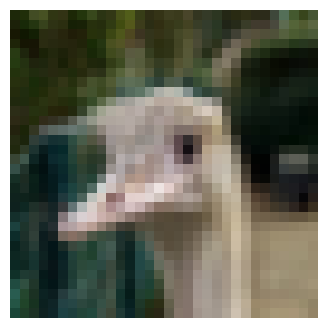

In [97]:
plt.figure(figsize=(4, 4))
image = attributs_entrainement[np.random.choice(range(attributs_entrainement.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

Taille image: 72 X 72
Taille tuile: 6 X 6
Nombre de tuiles par image: 144
Éléments par tuile: 108


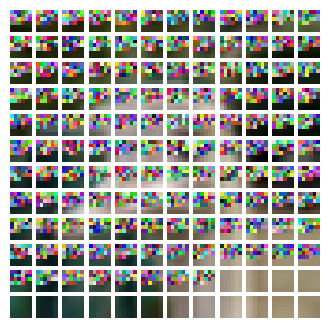

In [99]:
image_redimensionnee = ops.image.resize( ops.convert_to_tensor([image]), size=(taille_image, taille_image))

tuiles = Tuiles(taille_tuile)(image_redimensionnee)
print(f"Taille image: {taille_image} X {taille_image}")
print(f"Taille tuile: {taille_tuile} X {taille_tuile}")
print(f"Nombre de tuiles par image: {tuiles.shape[1]}")
print(f"Éléments par tuile: {tuiles.shape[-1]}")

n = int(np.sqrt(tuiles.shape[1]))
plt.figure(figsize=(4, 4))
for i, tuile in enumerate(tuiles[0]):
    ax = plt.subplot(n, n, i + 1)
    tuile_image = ops.reshape(tuile, (taille_tuile, taille_tuile, 3))
    plt.imshow(ops.convert_to_numpy(tuile_image).astype("uint8"))
    plt.axis("off")

##  Couche d'encodage de tuiles

La couche `EncodeurTuiles` transforme linéairement une tuile en la projetant dans un vecteur sémantique de taille `taille_vecteur_semantique`. De plus, il ajoute une position apprise par entraînement au vecteur sémantique.

In [100]:
class EncodeurTuiles(layers.Layer):
    def __init__(self, nombre_tuiles, taille_vecteur_semantique):
        super().__init__()
        self.nombre_tuiles = nombre_tuiles
        self.projection = layers.Dense(units=taille_vecteur_semantique)
        self.position_embedding = layers.Embedding(
            input_dim=nombre_tuiles, output_dim=taille_vecteur_semantique
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.nombre_tuiles, step=1), axis=0
        )
        tuiles_enrichies = self.projection(patch)
        tuiles_encodees = tuiles_enrichies + self.position_embedding(positions)
        return tuiles_encodees

    def get_config(self):
        config = super().get_config()
        config.update({"nombre_tuiles": self.nombre_tuiles})
        return config

print("EncodeurTuiles prêt")

EncodeurTuiles prêt


## Construire le réseau autoattenfif (ViT)

Le réseau de vision autoattenfif (ViT) se compose de plusieurs blocs autoattentif (Transformer), qui utilisent la couche `layers.MultiHeadAttention` comme mécanisme d'auto-attention appliqué à la séquence de tuiles. Les blocs autoattentifs produisent un Tenseur `[taille_lots, nombre_tuiles, taille_vecteur_semantique]`, qui est traité via un tête de classificateur avec softmax pour produire la sortie finale des probabilités pour chaque classe.
<br/><br/>
Contrairement à la technique décrite dans le [article](https://arxiv.org/abs/2010.11929), qui ajoute un vecteur sémantique appris par entraînement à la séquence de tuiles encodées pour servir de représentation de l'image, toutes les sorties du bloc autoattentif final sont remodelées avec une couche d'aplatissement `layers.Flatten()` et utilisées comme représentation de l'image comme entrée dans la tête du classificateur.
Notez que la couche `layers.GlobalAveragePooling1D` pourrait également être utilisée à la place pour agréger les sorties du bloc autoattentif,
surtout lorsque le nombre de tuiles et les dimensions du vecteur sémantque sont importants.

In [101]:
def classificateur_autoattentif():
    entrees = keras.Input(shape=dim_entree)
    # Amplifier les données
    donnnees_augmentees = amplification_donnees(entrees)
    # Créer des tuiles
    tuiles = Tuiles(taille_tuile)(donnnees_augmentees)
    # Encoder les tuiles
    tuiles_encodees = EncodeurTuiles(nombre_tuiles, taille_vecteur_semantique)(tuiles)
    # Créer plusieurs couches autoattentives
    for _ in range(nombre_couches_autoattentives):
        # couche de normalisation 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(tuiles_encodees)
        # Créer une couche autoattentive multi-têtes
        sortie_couche_attentive = layers.MultiHeadAttention(
            num_heads=nombre_tetes, key_dim=taille_vecteur_semantique, dropout=0.1
        )(x1, x1)
        # connexion résiduelle 1
        x2 = layers.Add()([sortie_couche_attentive, tuiles_encodees])
        # couche de normalisation 1.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # couche perceptron multicouche
        x3 = perceptron_multicouche(x3, unites_cachees=unite_autoattentive, taux_extinction=0.1)
        # connexion résiduelle 2
        encoded_patches = layers.Add()([x3, x2])

    # Crer un tenseur a [taille_lots, taille_vecteur_semantique]
    representation = layers.LayerNormalization(epsilon=1e-6)(tuiles_encodees)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Ajouter le perceptron multicouche de sortie
    attributs = perceptron_multicouche(representation, unites_cachees=unite_perceptron, taux_extinction=0.5)
    # Classifier les sorties
    logits = layers.Dense(nombre_classes)(attributs)
    # Créer le modèle Keras
    modele = keras.Model(inputs=entrees, outputs=logits)
    return modele

print("Classificateur_autoattentif prêt")

Classificateur_autoattentif prêt


## Entraîner, et évaluer le modèle

In [104]:
def entrainer_modele(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=taux_apprentissage, weight_decay=taux_decroissance_poids
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    traces = model.fit(
        x=attributs_entrainement,
        y=classes_cibles_entrainement,
        batch_size=taille_lots,
        epochs=nombre_epoques,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(attributs_test, classes_cibles_test)
    print(f"Exactitude sur les données de test: {round(accuracy * 100, 2)}%")
    print(f"Exactitude sur la prévision des 5 meilleurs: {round(top_5_accuracy * 100, 2)}%")

    return traces

modele_autoattentif = classificateur_autoattentif()
traces = entrainer_modele(modele_autoattentif)

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.2485 - loss: 2.9966 - top-5-accuracy: 0.7330 - val_accuracy: 0.3994 - val_loss: 1.6912 - val_top-5-accuracy: 0.8796
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.3547 - loss: 1.7996 - top-5-accuracy: 0.8470 - val_accuracy: 0.4496 - val_loss: 1.5649 - val_top-5-accuracy: 0.8990
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3885 - loss: 1.6994 - top-5-accuracy: 0.8664 - val_accuracy: 0.4692 - val_loss: 1.4920 - val_top-5-accuracy: 0.9166
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4111 - loss: 1.6440 - top-5-accuracy: 0.8823 - val_accuracy: 0.4866 - val_loss: 1.4449 - val_top-5-accuracy: 0.9214
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4249 - loss: 1.6076 - top-5-accuracy: 0.8902 - val_accuracy: 0.4852 - val_loss: 1.4176 - val_top-5-accuracy: 0.9254
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4379 - loss

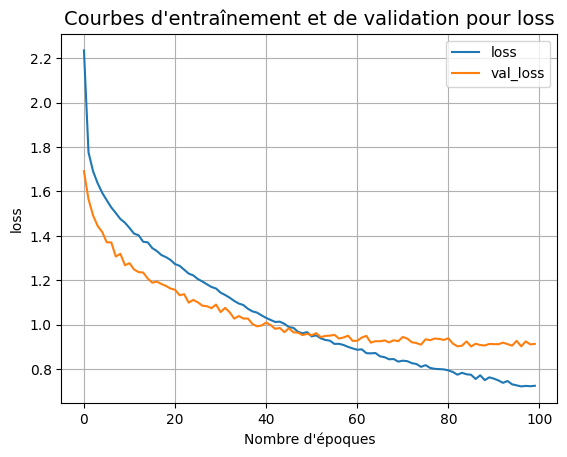

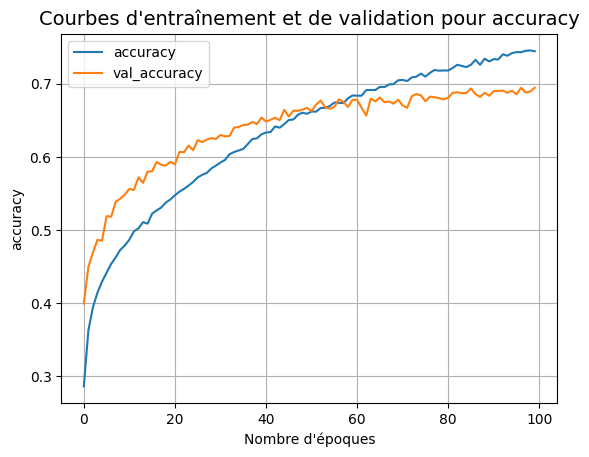

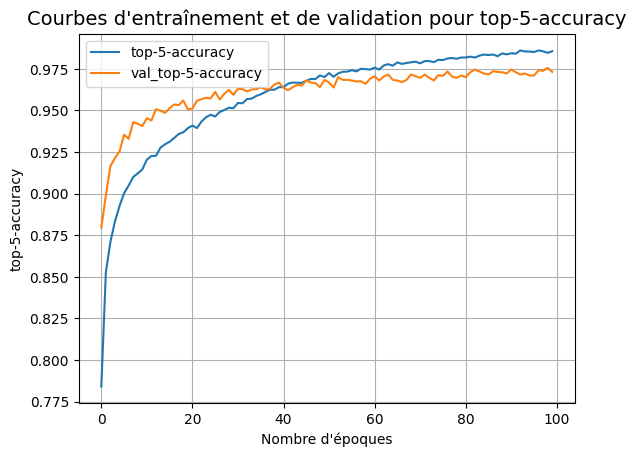

In [105]:
def afficher_traces(item):
    plt.plot(traces.history[item], label=item)
    plt.plot(traces.history["val_" + item], label="val_" + item)
    plt.xlabel("Nombre d'époques")
    plt.ylabel(item)
    plt.title("Courbes d'entraînement et de validation pour {}".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

afficher_traces("loss")
afficher_traces("accuracy")
afficher_traces("top-5-accuracy")

Après 100 époques, le modèle autoattentif atteint une exactitude d'environ 70 % sur les données de test et 97 % sur la prévision des cinq meilleures classes. Il ne s'agit pas de résultats compétitifs sur l'ensemble de données CIFAR-10,
car un ResNet50V2 entraîné à partir de zéro sur les mêmes données peut atteindre une précision de plus de 90 %.

Il convient de noter que les résultats de l'état de l'art rapportés dans le
[article](https://arxiv.org/abs/2010.11929) sont obtenus en pré-entraînant le modèle autoattentif à l'aide l'ensemble de données JFT-300M, puis l'affiner sur l'ensemble de données cible. Pour améliorer la qualité du modèle sans pré-entraînement, vous pouvez essayer d'entraîner le modèle pendant plus d'époques, utiliser un plus grand nombre de couches autoattentives, redimensionner les images d'entrée, modifier la taille des tuiles ou augmenter la dimension du vecteur sémantique.

En outre, comme mentionné dans l'article, la qualité du modèle n'est pas seulement affectée par les choix d'architecture, mais aussi par des paramètres tels que l'évolution du taux d'apprentissage, l'optimiseur, la perte de poids, etc.

En pratique, il est recommandé d'affiner un modèle ViT
qui a été pré-entraîné à l’aide d’un vaste ensemble de données à haute résolution.